###Import and installing packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import sqlite3
import random

from google.colab import data_table
data_table.enable_dataframe_formatter()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install --upgrade gdown

In [ ]:
plt.rcParams['font.size'] = '14'
color_palette = {0: 'palevioletred', 1: 'mediumseagreen' }

#Define the colormap at targets 0 and 1.
colors_0 = [(1, 1, 1), (0.858, 0.439, 0.576)]  # RGB values for white and palevioletred
cmap_0 = LinearSegmentedColormap.from_list('custom_cmap', colors_0)

colors_1 = [(1, 1, 1), (0.23529412, 0.70196078, 0.44313725)]  # RGB values for white and mediumseagreen
cmap_1 = LinearSegmentedColormap.from_list('custom_cmap', colors_1)

##Functions

In [ ]:
def display_data(conn):
    """
    This function returns a dataframe of the 5 first rows of the data.

    Parameters
    ----------
    conn: connection
        A connection object to the database.

    Returns
    -------
    dataframe
        A limited dataframe of the data.
    """
    cur = conn.cursor()
    sql1 = f'''SELECT
                    Device_ID, Datetime, URL, Domain_Name, Domain_cls1, Domain_cls2, Domain_cls3, Domain_cls4, Target
                FROM
                    data
                LIMIT
                    5;
                    '''
    cur.execute(sql1)
    df = pd.DataFrame(cur.fetchall(), columns = ['Device_ID', 'Datetime', 'URL', 'Domain_Name', 'Domain_cls1', 'Domain_cls2', 'Domain_cls3', 'Domain_cls4', 'Target'])
    return df

In [ ]:
def target_display(conn):
    """
    Pie charts of the Target distribution according to Device_ID and hits

    Parameters
    ----------
    conn: connection
        A connection object to the database.

    Returns
    -------
    -
    """
    cur = conn.cursor()
    sql1 = '''SELECT (COUNT(DISTINCT Device_ID)*100.0 / ((SELECT COUNT(DISTINCT Device_ID) FROM data)))
             FROM data
             WHERE Target=0;
             '''
    sql2 = '''SELECT (COUNT(*) * 100.0 / (SELECT COUNT(*) FROM data)) AS percentage
             FROM data
             WHERE Target=0;
             '''


    #Execute the first SQL query and display the results.
    cur.execute(sql1)
    users_target = pd.DataFrame(cur.fetchall(), columns = ['target_0'])
    users_target['target_1'] = 100-users_target['target_0']

    fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
    fig.tight_layout()
    wedges, texts, autotexts = ax[0].pie(users_target.iloc[0, :].values, autopct=lambda pct: f"{pct:.2f}%",
                                  textprops=dict(color="w"), colors=list(color_palette.values()))
    plt.setp(autotexts, size=8, weight="bold")
    ax[0].set_title("Device_ID according to the Target variable")
    ax[0].legend(wedges, ['target_0', 'target_1'], loc = 'lower center',bbox_to_anchor=(0.5, -0.2))

    #Execute the second SQL query and display the results.
    cur.execute(sql2)
    hits_target = pd.DataFrame(cur.fetchall(), columns = ['target_0'])
    hits_target['target_1'] = 100-hits_target['target_0']

    wedges, texts, autotexts = ax[1].pie(hits_target.iloc[0, :].values, autopct=lambda pct: f"{pct:.2f}%",
                                  textprops=dict(color="w"), colors=list(color_palette.values()))
    plt.setp(autotexts, size=8, weight="bold")
    ax[1].set_title("Samples (rows) according to the Target variable")
    ax[1].legend(wedges, ['target_0', 'target_1'], loc = 'lower center',bbox_to_anchor=(0.5, -0.2))

    plt.subplots_adjust(wspace=1.2)


In [ ]:
def unique_values(conn):
    """
    This function executes four queries that count the total unique values of Device_ID, URL, Domain_Name, and Domain_cls.

    Parameters
    ----------
    conn: connection
        A connection object to the database.

    Returns
    -------
    dataframe
        A dataframe with the mentioned fields and the numbers of distinct elements.
    """
    cur = conn.cursor()
    unique_values_dic = {}
    sql1 ='''SELECT COUNT(DISTINCT Device_ID) FROM data AS num_Device_ID;'''
    sql2 ='''SELECT COUNT(DISTINCT URL) FROM data AS num_URL;'''
    sql3 ='''SELECT COUNT(DISTINCT Domain_Name) FROM data AS num_Domain_Name;'''
    sql4 = '''SELECT COUNT(unique_value) FROM (
                SELECT DISTINCT Domain_cls1 AS unique_value FROM data WHERE Domain_cls1 !=0
                UNION
                SELECT DISTINCT Domain_cls2 AS unique_value FROM data WHERE Domain_cls2 !=0
                UNION
                SELECT DISTINCT Domain_cls3 AS unique_value FROM data WHERE Domain_cls3 !=0
                UNION
                SELECT DISTINCT Domain_cls4 AS unique_value FROM data WHERE Domain_cls4 !=0
                ) AS unique_values;'''

    cur.execute(sql1)
    unique_values_dic['num_Device_ID'] = cur.fetchall()[0][0]

    cur.execute(sql2)
    unique_values_dic['num_URL'] = cur.fetchall()[0][0]

    cur.execute(sql3)
    unique_values_dic['num_Domain_Name'] = cur.fetchall()[0][0]

    cur.execute(sql4)
    unique_values_dic['num_Domain_cls'] = cur.fetchall()[0][0]

    unique_values_df = pd.DataFrame.from_dict(unique_values_dic, orient='index', columns = ['#Total_unique_values'])
    return unique_values_df

In [ ]:
def histogram_url_domain_cls(conn):
    """
    Histograms of TOP 20 of the URL, Domain_Name and Domain_cls

    Parameters
    ----------
    conn: connection
        A connection object to the database.

    Returns
    -------
    -
    """
    cur = conn.cursor()
    sql1 = '''SELECT URL, COUNT(URL) AS occurrence
              FROM data
              GROUP BY URL
              ORDER BY occurrence DESC
              LIMIT 20;
             '''
    sql2 = '''SELECT Domain_Name, COUNT(Domain_Name) AS occurrence
              FROM data
              GROUP BY Domain_Name
              ORDER BY occurrence DESC
              LIMIT 20;
             '''
    sql3 = '''SELECT unique_value, COUNT(*) AS occurrence
                FROM (
                    SELECT Domain_cls1 AS unique_value FROM data
                    UNION ALL
                    SELECT Domain_cls2 AS unique_value FROM data
                    UNION ALL
                    SELECT Domain_cls3 AS unique_value FROM data
                    UNION ALL
                    SELECT Domain_cls4 AS unique_value FROM data
                ) AS all_values
                GROUP BY unique_value
                ORDER BY occurrence DESC
                LIMIT 21;
                '''
    cur.execute(sql1)
    queries_df = pd.DataFrame(cur.fetchall(), columns = ['URL', 'count'])
    queries_df['URL'] = queries_df['URL'].astype('str')

    cur.execute(sql2)
    subqueries_df = pd.DataFrame(cur.fetchall(), columns = ['Domain_Name', 'count'])
    subqueries_df['Domain_Name'] = subqueries_df['Domain_Name'].astype('str')

    cur.execute(sql3)
    cat_df = pd.DataFrame(cur.fetchall(), columns = ['Domain_cls', 'count'])
    cat_df = cat_df.loc[~(cat_df.Domain_cls==0)]
    cat_df['Domain_cls'] = cat_df['Domain_cls'].astype('str')


    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(30, 24))
    plt.subplots_adjust(hspace = 0.4)

    sns.barplot(x='count',
            y="URL", data=queries_df, color = 'slategrey', ax=ax1)
    for container in ax1.containers:
        ax1.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
    ax1.set_title('URL histogram - TOP 20', fontsize=18)

    sns.barplot(x='count',
            y="Domain_Name", data=subqueries_df, color = 'slategrey', ax=ax2)
    for container in ax2.containers:
        ax2.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
    ax2.set_title('Domain_Name histogram - TOP 20', fontsize=18)

    sns.barplot(x='count',
            y="Domain_cls", data=cat_df, color = 'slategrey', ax=ax3)
    for container in ax3.containers:
        ax3.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues])
    ax3.set_title('Domain_cls histogram - TOP 20', fontsize=18)

In [ ]:
def avg_relative_entrances_device_id(conn, hours_duration):
    """
    Visualization of the proportional hits according to the day's parts and the Target variable.
    Calculation of proportional hits: For each Device_ID, sum up the proportional hits for each day's part (calculated each day) and divide them by the number of days (all days of internet usage -queries).

    Parameters
    ----------
    conn: connection
        A connection object to the database.
    hours_duration : int
        The interval duration of each day's parts in hours (Day division to 24/'hours_duration' parts).

    Returns
    -------
    -
    """
    df_sum_relative = sum_relative_entrances_timerange(conn, hours_duration)

    all_desired_combinations = list(pd.MultiIndex.from_product([df_sum_relative['Device_ID'].unique(), range(int(24/hours_duration))], names=['Device_ID', 'time_range']))
    diff_to_add = set(all_desired_combinations).difference(set(df_sum_relative.apply(lambda row: (row['Device_ID'], row['time_range']), axis=1).to_list()))
    diff_to_add = [x +(0,) for x in diff_to_add]
    diff_to_add_df = pd.DataFrame(diff_to_add, columns = list(df_sum_relative.columns))
    df_sum_relative = pd.concat([df_sum_relative,diff_to_add_df], axis=0)
    df_sum_relative.reset_index(drop = True, inplace = True)

    df_days_count_train = count_day_device_id(conn)

    df_relative = pd.merge(df_sum_relative, df_days_count_train, how ='left', on ='Device_ID')
    df_relative['relative_part'] = df_relative['sum_relative_part']/df_relative['day_num']
    df_relative.drop(['day_num','sum_relative_part'],axis=1, inplace = True)

    df_relative['Target'] = df_relative['Target'].astype('int')

    plt.figure(figsize = (30, 8))
    time_ranges = get_time_ranges(hours_duration)
    g = sns.boxplot(data=df_relative, x="time_range", y="relative_part", hue = 'Target', saturation = 2.7, palette=color_palette)
    plt.xticks(ticks=np.arange(0, len(time_ranges)), labels=time_ranges)

    plt.title(f"Box plot of proportional hits to websites according to part of the day for each target", fontsize = 22)
    plt.show()

In [ ]:
def sum_relative_entrances_timerange(conn, hours_duration):
    """
    For each Device_ID, sum the proportional hits in each day according to the day's parts.

    Parameters
    ----------
    conn: connection
        A connection object to the database.
    hours_duration : int
        The interval duration of each day's parts in hours (Day division to 24/'hours_duration' parts).

    Returns
    -------
    dataframe
        A dataframe contains Device_ID, part of the day, and the sum of the proportional hits.
    """
    cur = conn.cursor()
    sql = f'''SELECT DISTINCT
                        Device_ID,
                        time_range,
                        SUM (relative_part) OVER (PARTITION BY Device_ID,time_range) AS sum_relative_part
                    FROM(

                            SELECT distinct
                                            Device_ID,
                                            date,
                                            time_range,
                                            CAST(COUNT(*) OVER (PARTITION BY Device_ID,date,time_range) AS REAL) / COUNT(*) OVER (PARTITION BY Device_ID,date) AS relative_part
                                        FROM
                                                    (SELECT
                                                            Device_ID,
                                                            Datetime,
                                                            strftime('%Y-%m-%d', Datetime) AS date,
                                                            (CAST(strftime('%H', Datetime) AS INTEGER) / {hours_duration}) AS time_range
                                                        FROM
                                                            data
                                                    ) subquery
                        ) subquery
                        ;'''

    cur.execute(sql)
    df = pd.DataFrame(cur.fetchall(), columns = ['Device_ID','time_range', 'sum_relative_part'])
    return df

In [ ]:
def count_day_device_id(conn):
    """
    This function counts the days with internet usage(queries) of each Device_ID.

    Parameters
    ----------
    conn: connection
        A connection object to the database.

    Returns
    -------
    dataframe
        A dataframe contains Device_ID, total days and Target.
    """
    cur = conn.cursor()
    sql1 = f'''
                SELECT
                    Device_ID,
                    COUNT(DISTINCT strftime('%Y-%m-%d', Datetime)) AS day_num,
                    Target
                FROM
                    data
                GROUP BY
                    Device_ID
                ;'''
    cur.execute(sql1)
    df = pd.DataFrame(cur.fetchall(), columns = ['Device_ID', 'day_num', 'Target'])

    return df

In [ ]:
def get_time_ranges(interval_duration):
    """
    Get the interval duration of each part of the day and return a list of the parts in readable format.

    Parameters
    ----------
    interval_duration: int
        The interval duration of each day's parts in hours (Day division to 24/'hours_duration' parts).

    Returns
    -------
    list
        list of parts of the day.
    """
    time_ranges = [f"{i:02d}-{(i + interval_duration) % 24:02d}" for i in range(0, 24, interval_duration)]
    return time_ranges

In [ ]:
def avg_relative_entrances_device_id_by_day(conn, hours_duration):
    """
    Bar plot of the proportional hits according to the day's parts, days of the week, and the Target variable.
    Calculation of proportional hits: For each Device_ID, for each day of the week, sum up the proportional hits for each day's part (calculated each day) and divide them by the number of days (all days of internet usage -queries)

    Parameters
    ----------
    conn: connection
        A connection object to the database.
    hours_duration : int
        The interval duration of each day's parts in hours (Day division to 24/'hours_duration' parts).

    Returns
    -------
    -
    """
    cur = conn.cursor()
    sql = f'''SELECT distinct
                    Device_ID,
                    date,
                    time_range,
                    CAST(COUNT(*) OVER (PARTITION BY Device_ID,date,time_range) AS REAL) / COUNT(*) OVER (PARTITION BY Device_ID,date) AS relative_part,
                    Target
                FROM
                            (SELECT
                                    Device_ID,
                                    Datetime,
                                    strftime('%Y-%m-%d', Datetime) AS date,
                                    (CAST(strftime('%H', Datetime) AS INTEGER) / {hours_duration}) AS time_range,
                                    Target
                                FROM
                                    data
                            ) subquery;'''
    cur.execute(sql)
    df = pd.DataFrame(cur.fetchall(), columns = ['Device_ID','date','time_range', 'relative_part', 'Target'])
    df['date'] = pd.to_datetime(df.date)
    df['day_of_week'] = df['date'].dt.day_name()
    df['Target'] = df['Target'].astype('int')
    sum_according_day = df.groupby(['Device_ID', 'day_of_week', 'time_range'])['relative_part'].sum()
    sum_according_day = sum_according_day.to_frame().reset_index()
    count_days = df.groupby(['Device_ID', 'day_of_week'])['date'].nunique()
    count_days = count_days.to_frame().reset_index()
    relative_df = pd.merge(sum_according_day, count_days, on=['Device_ID', 'day_of_week'], how='left')
    relative_df['relative_part'] = relative_df['relative_part']/relative_df['date']
    relative_df.drop(columns = ['date'], inplace = True)

    #Adding missing combinations of time_range, day_of_week, and Device_ID with a value of 0.
    all_desired_combinations = list(pd.MultiIndex.from_product([df['Device_ID'].unique(), df['day_of_week'].unique(), range(int(24/hours_duration))], names=['Device_ID', 'day_of_week', 'time_range']))
    to_add = set(all_desired_combinations).difference(set(relative_df.apply(lambda row: (row['Device_ID'], row['day_of_week'], row['time_range']), axis=1).to_list()))
    diff_to_add = [x +(0,) for x in to_add]
    diff_to_add_df = pd.DataFrame(diff_to_add, columns = list(relative_df.columns))
    relative_df = pd.concat([relative_df,diff_to_add_df], axis=0)
    relative_df.reset_index(drop = True, inplace = True)
    relative_df = pd.merge(relative_df, df[['Device_ID', 'Target']].drop_duplicates().reset_index(drop=True), on=['Device_ID'], how='left')
    time_ranges = get_time_ranges(hours_duration)
    plt.figure(figsize=(15,8))
    sns.catplot(data=relative_df, x='time_range', y='relative_part',
        col='day_of_week', kind='bar' ,hue="Target", palette=color_palette, col_order = ['Sunday', 'Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    plt.xticks(ticks=np.arange(0, len(time_ranges)), labels=time_ranges)
    plt.title('Proportional hits to websites according to a day of week and part of the day for each target', y=1.1, x=-2.5, fontsize = 22)

In [ ]:
def domain_ratio_by_target(conn, sql, feature, filter_conditions):
    """
    Calculating proportional Device_ID and proportional hits for feature (Domain_Name/Domain_cls) according to the Target variable.

    Parameters
    ----------
    conn: connection
        A connection object to the database.
    sql: query
        A query of counting elements for each Device_ID.
    feature : str
        The feature to be count.
    filter_conditions: dictionary
        Thresholds to filter and display the results (for the required feature number of device_ids and proportional of device_ids and proportional of hits)

    Returns
    -------
    -
    """
    cur = conn.cursor()
    cur.execute(sql)
    df = pd.DataFrame(cur.fetchall(), columns = ['Device_ID', 'Target', 'Domain', 'Domain_count'])
    df['Domain'] = df['Domain'].astype('str')

    domain_count = df.sort_values(['Domain', 'Target']).groupby(['Domain', 'Target']).agg({"Domain_count": [np.sum], "Device_ID": [np.size]}).reset_index()
    domain_count.columns = domain_count.columns.droplevel(1)
    domain_count.rename(columns = {'Domain_count': 'Domain_sum', 'Device_ID': 'Device_ID_count'}, inplace = True)

    domain_count['proportional_Domain'] = domain_count['Domain_sum'] / domain_count.groupby('Domain')['Domain_sum'].transform('sum')
    domain_count['proportional_Device_ID'] = domain_count['Device_ID_count'] / domain_count.groupby('Domain')['Device_ID_count'].transform('sum')

    domain_count_list = list(domain_count.loc[(domain_count.Device_ID_count>filter_conditions['num_device_ids']) & (domain_count.proportional_Device_ID>filter_conditions['proportional_Device_ID'])
     & (domain_count.proportional_Domain>filter_conditions['proportional_Domain'])].Domain)
    domain_count_filter = domain_count[domain_count.Domain.isin(domain_count_list)]

    pivot_df = domain_count_filter.pivot_table(index='Domain', columns='Target',
                          values=['proportional_Domain', 'proportional_Device_ID'])
    pivot_df.columns = [f'Target_{target}_'+level for level, target in pivot_df.columns]

    pivot_df_1 = pivot_df[['Target_1_proportional_Domain', 'Target_1_proportional_Device_ID']]
    pivot_df_1.rename(columns = {'Target_1_proportional_Domain':f'proportional_hits', 'Target_1_proportional_Device_ID':'proportional_Device_ID'}, inplace = True)

    pivot_df_0 = pivot_df[['Target_0_proportional_Domain', 'Target_0_proportional_Device_ID']]
    pivot_df_0.rename(columns = {'Target_0_proportional_Domain':f'proportional_hits', 'Target_0_proportional_Device_ID':'proportional_Device_ID'}, inplace = True)

    fig, axes = plt.subplots(1, 2, figsize=(15, 15), sharey=True)

    # Plot the first heatmap on the first subplot
    sns.heatmap(pivot_df_0, cmap=cmap_0, vmin=0, vmax=1, annot=True, fmt =".2%", ax=axes[0], cbar = False)
    axes[0].set_ylabel(f'Domain_{feature}')
    axes[0].set_title('Target_0')
    axes[0].xaxis.tick_top()


    # Plot the second heatmap on the second subplot
    sns.heatmap(pivot_df_1, cmap=cmap_1,vmin=0, vmax=1, annot=True, fmt =".2%", ax=axes[1], cbar = False)
    axes[1].set_ylabel(f'Domain_{feature}')
    axes[1].set_title('Target_1')
    axes[1].xaxis.tick_top()


    plt.tight_layout()
    plt.show()

##Download training data

Select the data for analysis and display.
(note that running the notebook on the full dataset will not be possible in a standard collab)

In [ ]:
dataset = "full dataset" #@param ["full dataset", "mini dataset"]

print('You selected', dataset)
if dataset == "mini dataset":
    !gdown --fuzzy "https://drive.google.com/file/d/1NdgwhvUGxVxmv14GTEEgfvlzco_N5Ytc/view?usp=sharing"
    !unzip "/content/mini_training_set.zip"
    conn = sqlite3.connect("/content/mini_training_set.db")
else:
    !gdown --fuzzy "https://drive.google.com/file/d/1DdJFPcaOGa3grUdygEti8jaWjrReyeQU/view?usp=sharing"
    !unzip "/content/training_set.zip"
    conn = sqlite3.connect("/content/training_set.db")

You selected full dataset


##EDA

###Overview

The competition's data consists of the following columns:
1.   Device_ID -unique identifier for the user
2.   Datetime - Time indicating the entrance to the website
3. URL - unique identifier for URL
4. Domain_Name - unique identifier for domain
5. Domain_cls1-4 - Domain classification - up to 4 categories per domain
6. Target - Categorical target variable - 0/1


In [ ]:
data_head = display_data(conn)
data_head

,Device_ID,Datetime,URL,Domain_Name,Domain_cls1,Domain_cls2,Domain_cls3,Domain_cls4,Target
0,15,2023-04-23 08:27:52+03:00,1028748,1913366,336,0,0,0,0
1,15,2023-04-23 08:27:52+03:00,463904,1601322,332,0,0,0,0
2,15,2023-04-23 08:27:53+03:00,1960179,1080716,544,0,0,0,0
3,15,2023-04-23 08:27:53+03:00,2297508,1913366,336,0,0,0,0
4,15,2023-04-23 08:27:53+03:00,833686,733119,96,0,0,0,0


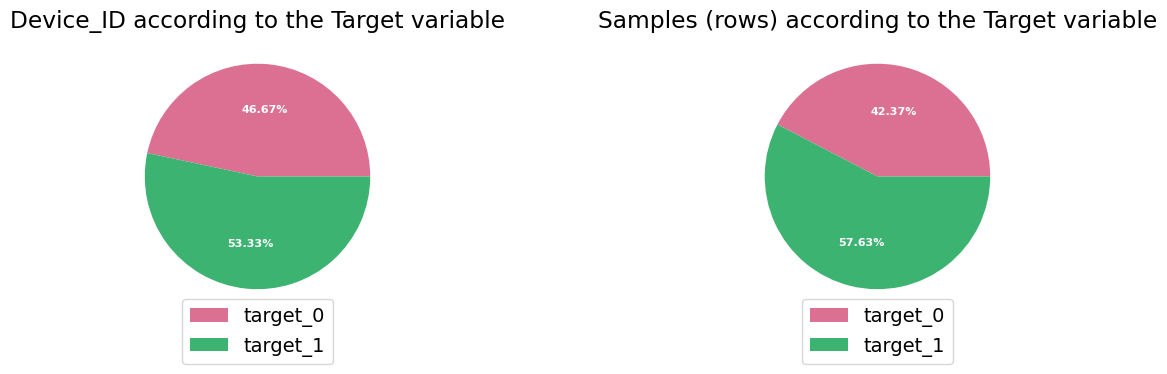

In [ ]:
target_display(conn)

In [ ]:
#The total unique values ​​of the following fields: Device_ID, URL, Domain_Name, Domain_cls
unique_values_df = unique_values(conn)
unique_values_df

,#Total_unique_values
num_Device_ID,6154
num_URL,668781
num_Domain_Name,111264
num_Domain_cls,165


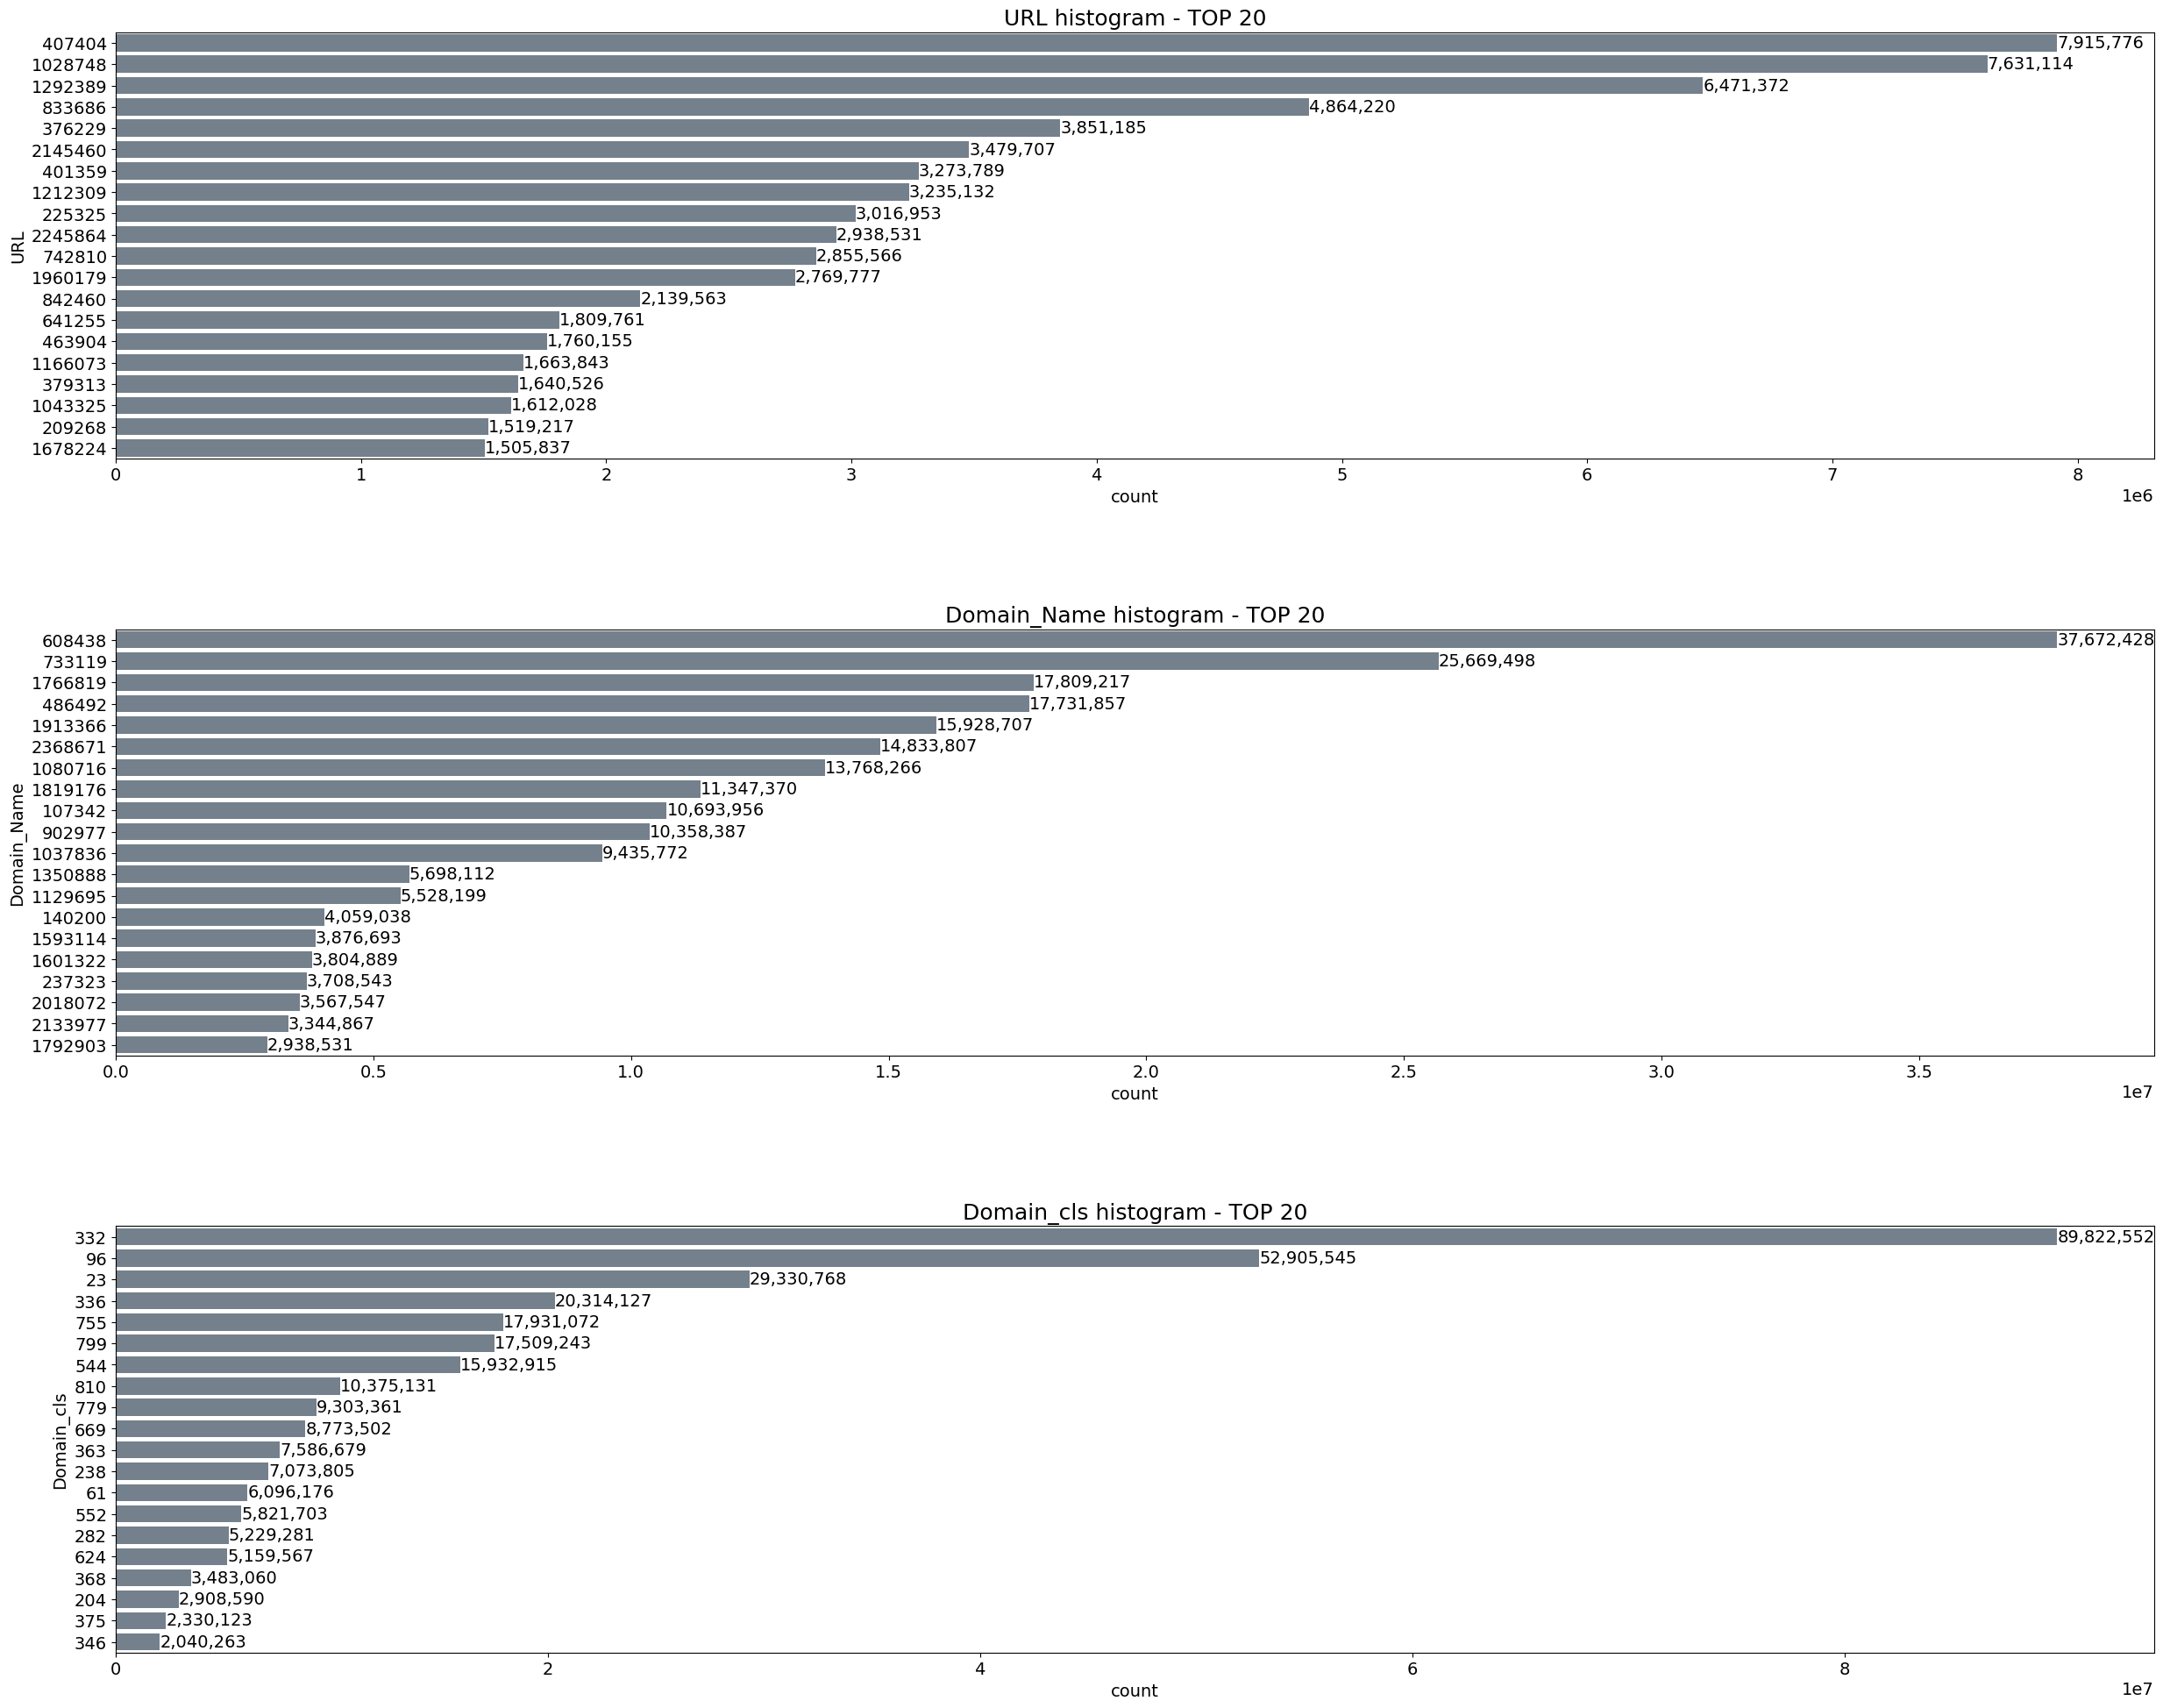

In [ ]:
histogram_url_domain_cls(conn)

##Analysis of the data and the target variable


Select duration of day's bins (hours):

In [ ]:
hours_duration = "3" # @param ["2", "3", "4", "6", "8"]
hours_duration = int(hours_duration)

For example, for a duration of 3 hours, the calculations will be for these time ranges:

00:00-00:03, 03:00-06:00, 06:00-09:00, 09:00-12:00, 12:00-15:00, 15:00-18:00, 18:00-21:00, 21:00-24:00

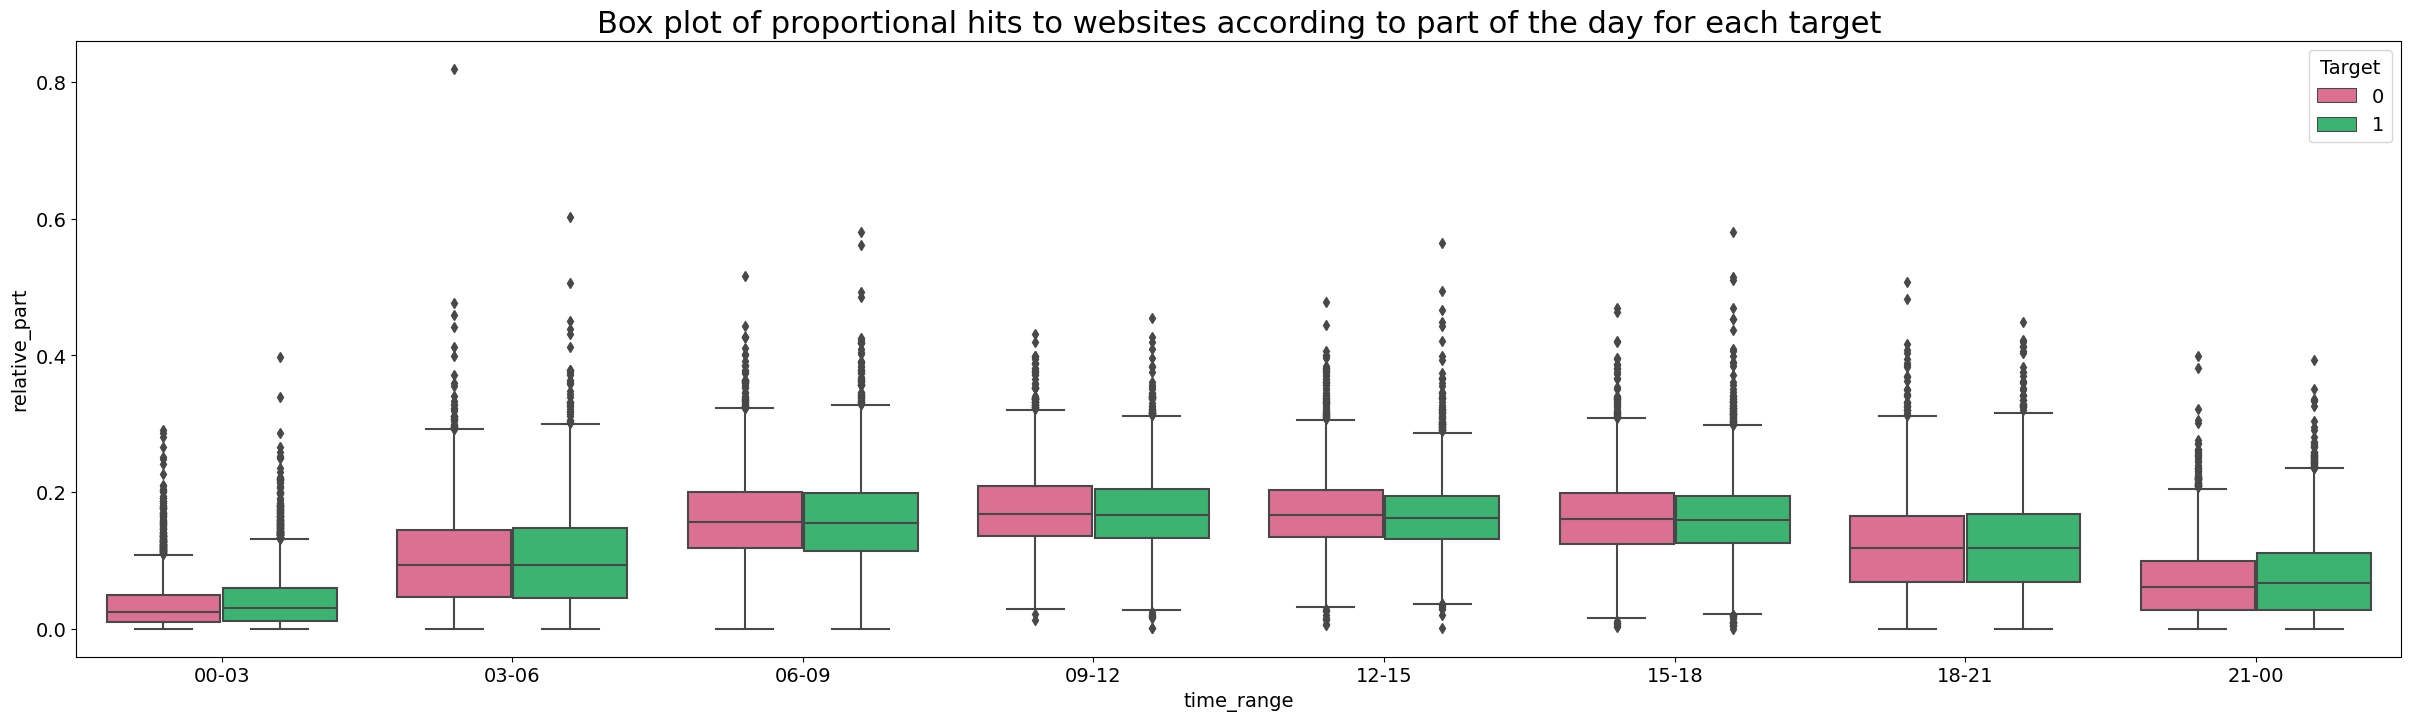

In [ ]:
#The proportional web-hits according to the day's parts and the Target variable
#Calculation of proportional web-hits: For each Device_ID, sum up the proportional hits for each day's part (calculated each day) and divide them by the number of days (all days of internet usage -queries).
avg_relative_entrances_device_id(conn, hours_duration)

<Figure size 1500x800 with 0 Axes>

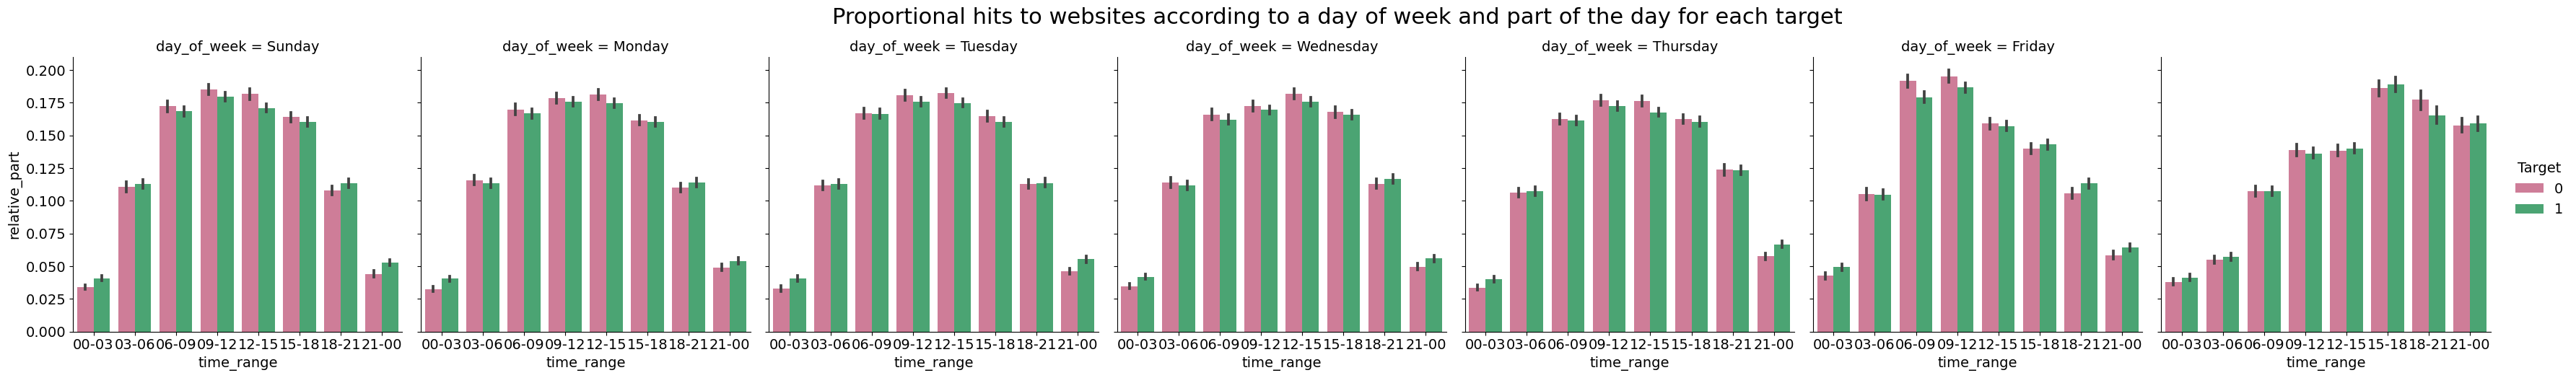

In [ ]:
#The proportional web-hits according to the day's parts, days of the week, and the Target variable.
#Calculation of proportional hits: For each Device_ID, for each day of the week, sum up the proportional hits for each day's part (calculated each day) and divide them by the number of days (all days of internet usage -queries)
avg_relative_entrances_device_id_by_day(conn, hours_duration)

Analysis of the percentage of domains visits according to hits ('proportional_hits') and unique device ID ('proportional_Device_ID').
Display the domains whose calculated ratios are higher than 0.95 and have more than 50 unique device_id.

For example:
3.08% of the unique Device_ID that enter Domain '1375857'  are from target 0 and 96.92% are from target 1.
1.19% of the total hits are from Target 0, and 98.81% are from Target 1.

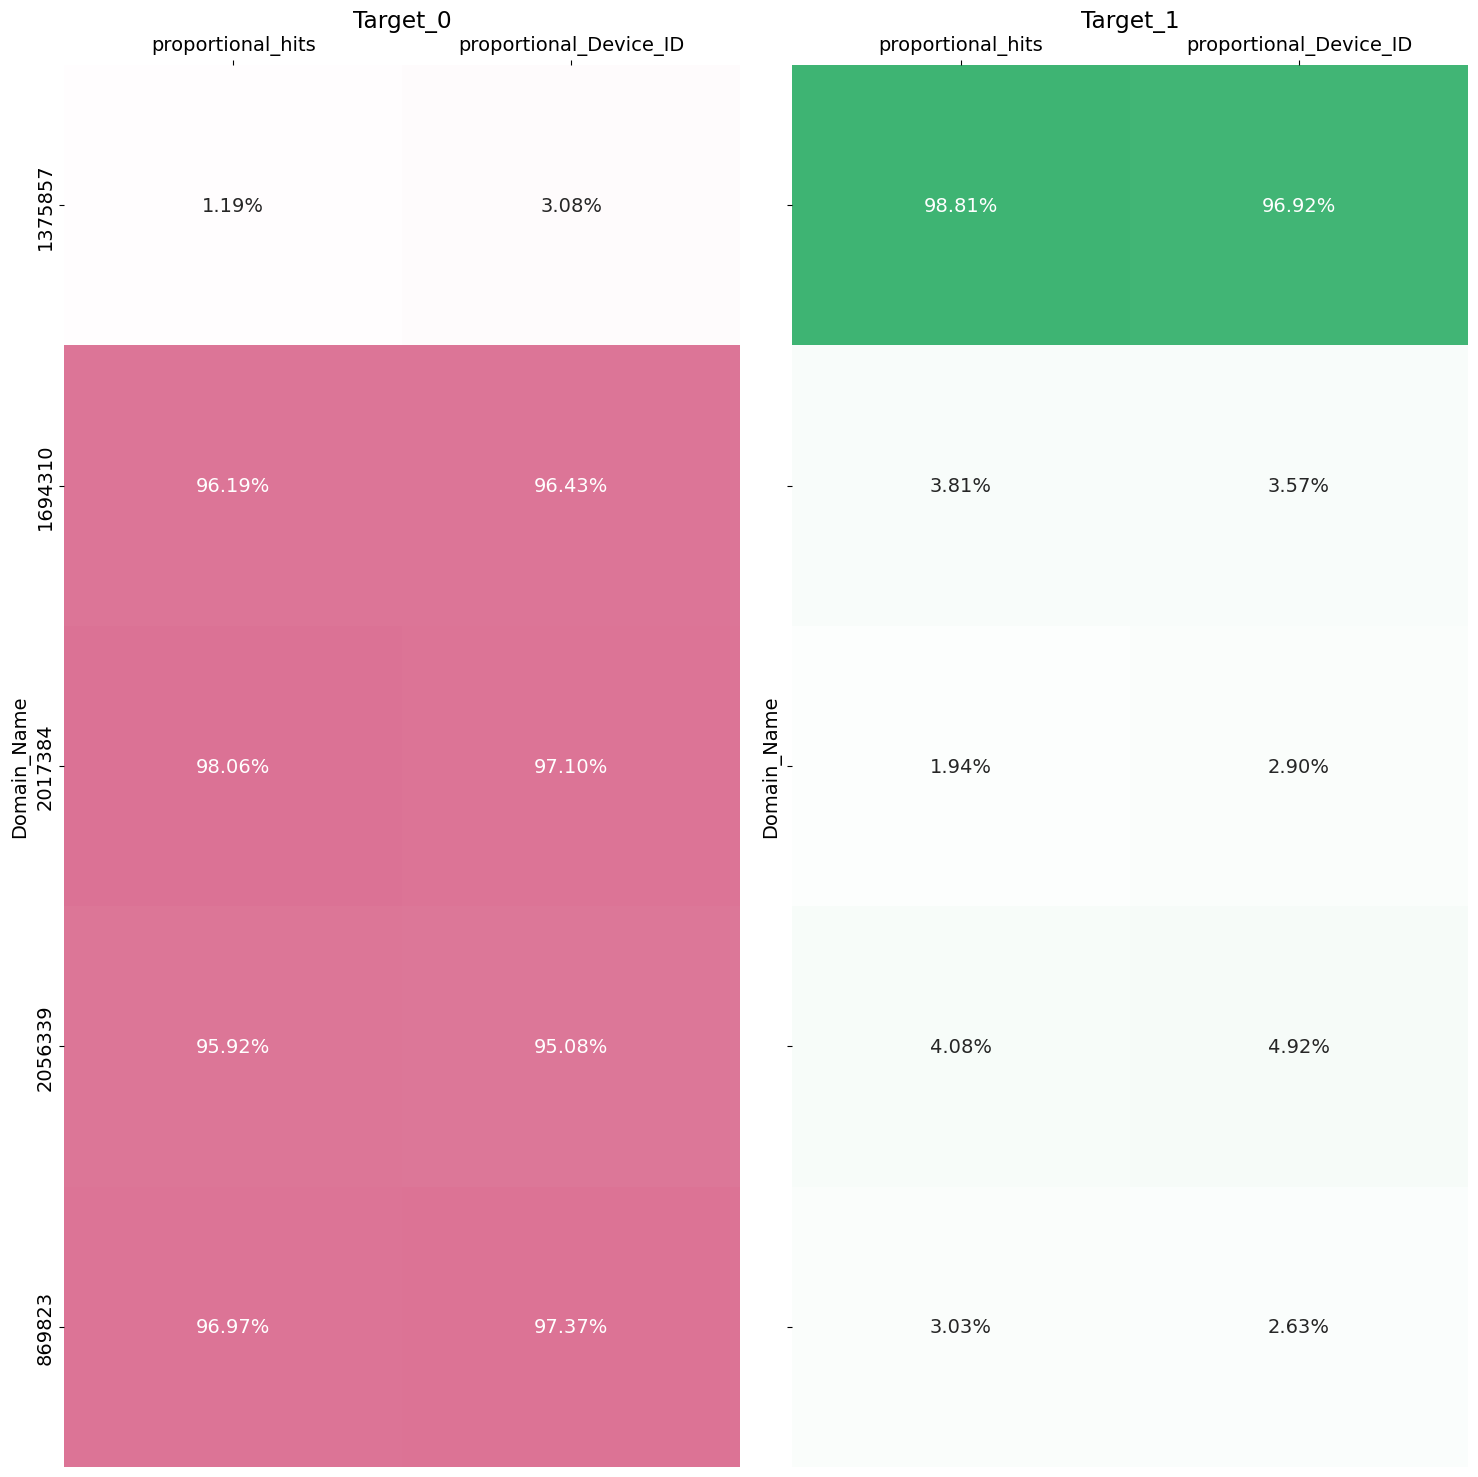

In [ ]:
filter_conditions = {'num_device_ids':50, 'proportional_Domain':0.95,'proportional_Device_ID':0.95}
sql = f'''SELECT Device_ID, Target, Domain_Name, count(*) as Domain_Name_count
            from data
            group BY Device_ID, Domain_Name;'''

domain_ratio_by_target(conn, sql, 'Name', filter_conditions)

Analysis of the percentage of domain_cls visits according to hits ('proportional_hits') and unique device ID ('proportional_Device_ID').
Display the domain_cls whose calculated ratios are higher than 0.7 and have more than 20 unique device_id.

For example:
75.88% of the unique Device_ID that enter domains from Domain_cls  '159'  are from target 0 and 24.12% are from target 1.
74.32% of the total hits are from Target 0, and 25.68% are from Target 0.

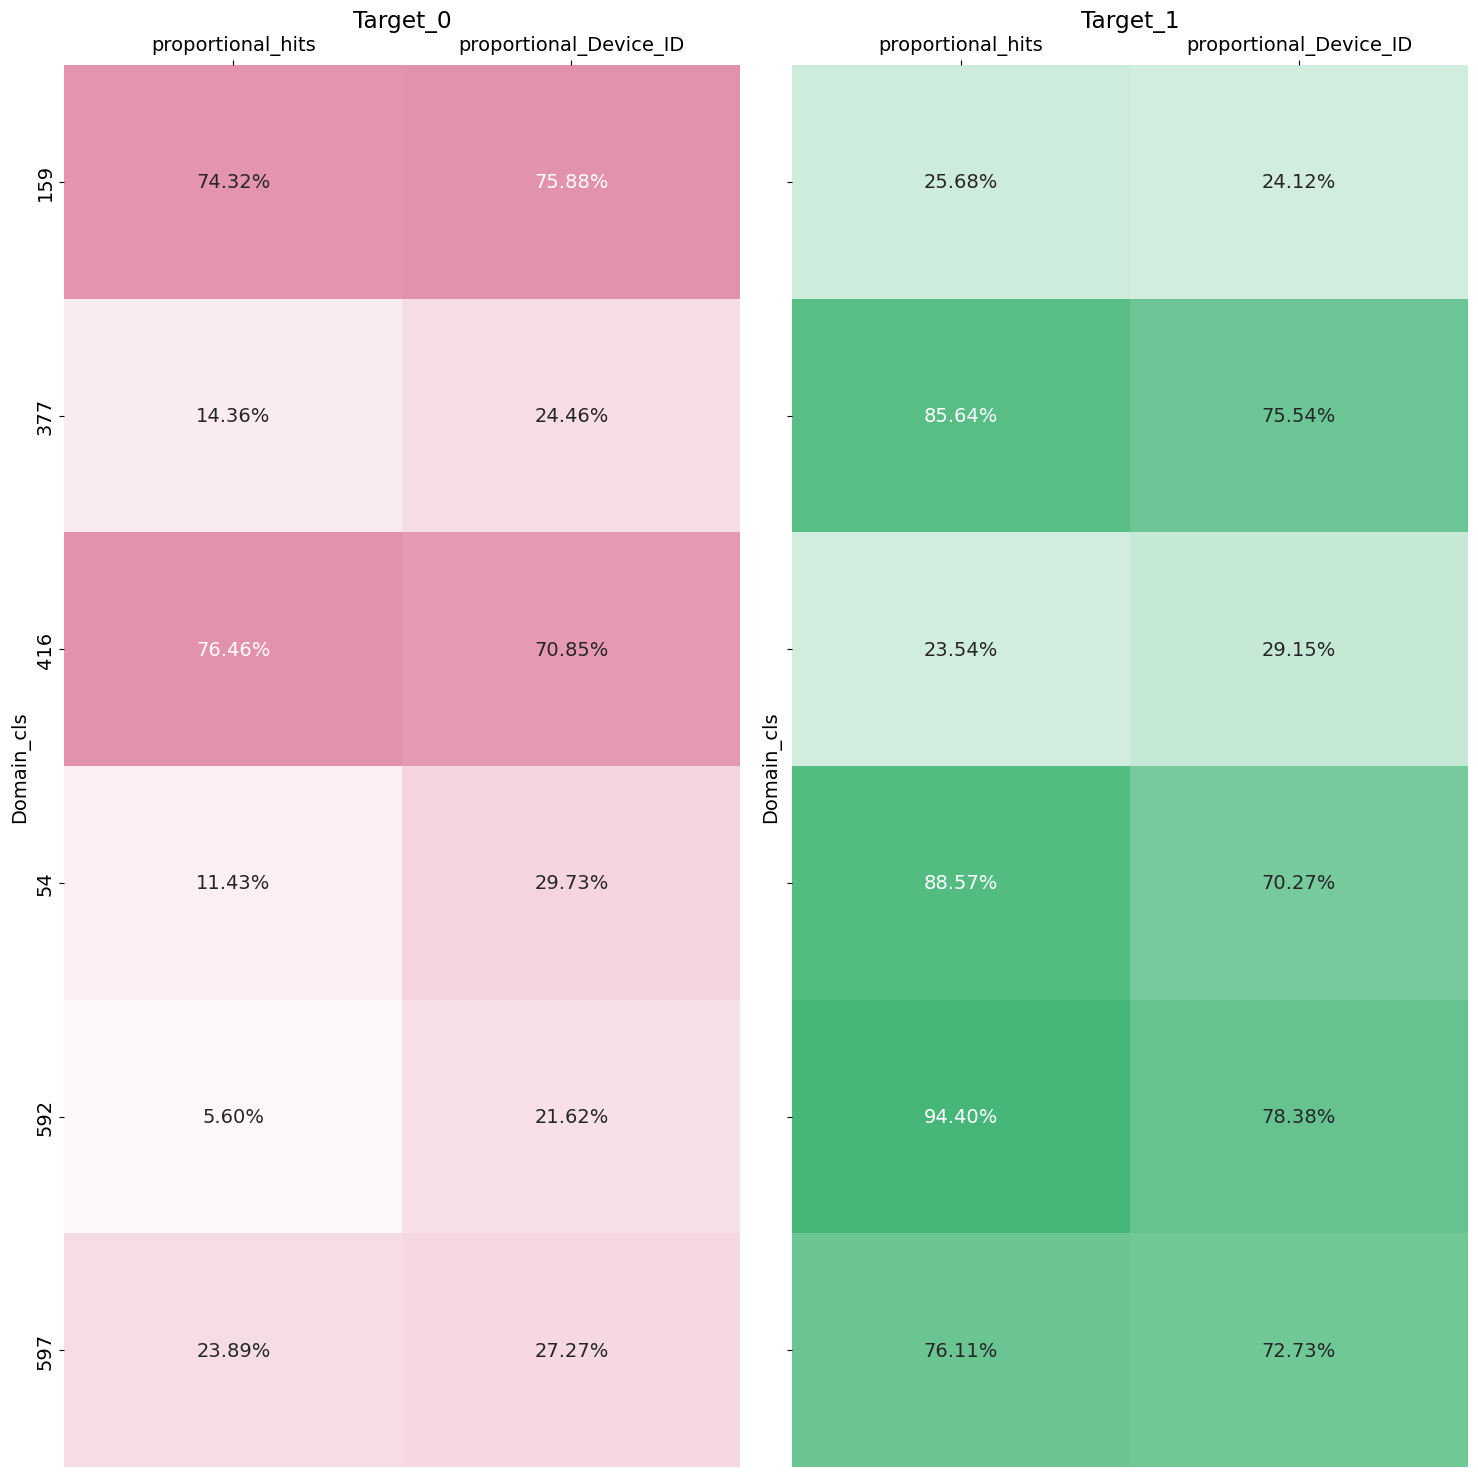

In [ ]:
sql  = '''SELECT Device_ID, Target, Domain_cls , COUNT(*) AS cls_count
                    FROM (
                        SELECT Device_ID, Target, Domain_cls1 AS Domain_cls FROM data WHERE Domain_cls1 !=0
                        UNION ALL
                        SELECT Device_ID, Target, Domain_cls2 AS Domain_cls FROM data WHERE Domain_cls2 !=0
                        UNION ALL
                        SELECT Device_ID, Target, Domain_cls3 AS Domain_cls FROM data WHERE Domain_cls3 !=0
                        UNION ALL
                        SELECT Device_ID, Target, Domain_cls4 AS Domain_cls FROM data WHERE Domain_cls4 !=0
                    ) AS combined
                    WHERE Domain_cls!=0
                    GROUP BY Device_ID, Domain_cls
                    ORDER BY Device_ID, Domain_cls;'''
filter_conditions = {'num_device_ids':20, 'proportional_Domain':0.70,'proportional_Device_ID':0.70}
domain_ratio_by_target(conn, sql, 'cls', filter_conditions)